<a href="https://colab.research.google.com/github/orlandojmarin/gender-identification-from-face-images/blob/main/Code_Gender_Identification_from_Face_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# ORLANDO MARIN

# GitHub Repository URL: https://github.com/orlandojmarin/gender-identification-from-face-images

# --------------------------------------------------------------------
# IMPORT LIBRARIES
# --------------------------------------------------------------------
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------------
# LOAD DATA
# --------------------------------------------------------------------
# Read the CSV file from GitHub into a pandas dataframe
data = pd.read_csv("https://raw.githubusercontent.com/orlandojmarin/gender-identification-from-face-images/refs/heads/main/gender_id_from_face_images_data.csv")

# --------------------------------------------------------------------
# HELPER FUNCTION: DISTANCE BETWEEN TWO POINTS
# --------------------------------------------------------------------
def distance(x1, y1, x2, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

# --------------------------------------------------------------------
# FEATURE CALCULATIONS
# --------------------------------------------------------------------
def eye_length_ratio(row):
    left_eye = distance(row["x9"], row["y9"], row["x10"], row["y10"])
    right_eye = distance(row["x11"], row["y11"], row["x12"], row["y12"])
    base = distance(row["x8"], row["y8"], row["x13"], row["y13"])
    return max(left_eye, right_eye) / base if base != 0 else 0

def eye_distance_ratio(row):
    distance_eye_center = distance(row["x0"], row["y0"], row["x1"], row["y1"])
    base = distance(row["x8"], row["y8"], row["x13"], row["y13"])
    return distance_eye_center / base if base != 0 else 0

def nose_ratio(row):
    numerator = distance(row["x15"], row["y15"], row["x16"], row["y16"])
    denominator = distance(row["x20"], row["y20"], row["x21"], row["y21"])
    return numerator / denominator if denominator != 0 else 0

def lip_size_ratio(row):
    numerator = distance(row["x2"], row["y2"], row["x3"], row["y3"])
    denominator = distance(row["x17"], row["y17"], row["x18"], row["y18"])
    return numerator / denominator if denominator != 0 else 0

def lip_length_ratio(row):
    numerator = distance(row["x2"], row["y2"], row["x3"], row["y3"])
    denominator = distance(row["x20"], row["y20"], row["x21"], row["y21"])
    return numerator / denominator if denominator != 0 else 0

def eyebrow_length_ratio(row):
    eyebrow_one = distance(row["x4"], row["y4"], row["x5"], row["y5"])
    eyebrow_two = distance(row["x6"], row["y6"], row["x7"], row["y7"])
    numerator = max(eyebrow_one, eyebrow_two)
    denominator = distance(row["x8"], row["y8"], row["x13"], row["y13"])
    return numerator / denominator if denominator != 0 else 0

def aggressive_ratio(row):
    numerator = distance(row["x10"], row["y10"], row["x19"], row["y19"])
    denominator = distance(row["x20"], row["y20"], row["x21"], row["y21"])
    return numerator / denominator if denominator != 0 else 0

# --------------------------------------------------------------------
# DATA CLEANING FUNCTION
# --------------------------------------------------------------------
def clean_data(df):
    df = df.copy()

    # Clean filename
    df["filename_clean"] = df["filename"].str.replace(".pts", "", regex=False)
    df[["gender_file", "unique_person_id", "expression_or_lighting"]] = df["filename_clean"].str.split("-", n=2, expand=True)
    df.drop(columns=["filename_clean", "gender_file", "filename"], inplace=True)

    # Drop invalid data
    df = df[df["expression_or_lighting"] != "05_a"]

    # Encode gender
    le = LabelEncoder()
    df["gender_label"] = le.fit_transform(df["gender"])

    # Reorder columns
    front_cols = ["gender_label", "gender", "unique_person_id", "expression_or_lighting"]
    other_cols = [col for col in df.columns if col not in front_cols]
    return df[front_cols + other_cols]

# --------------------------------------------------------------------
# FEATURE ENGINEERING FUNCTION
# --------------------------------------------------------------------
def feature_engineering(df):
    df = df.copy()
    df["eye_length_ratio"] = df.apply(eye_length_ratio, axis=1)
    df["eye_distance_ratio"] = df.apply(eye_distance_ratio, axis=1)
    df["nose_ratio"] = df.apply(nose_ratio, axis=1)
    df["lip_size_ratio"] = df.apply(lip_size_ratio, axis=1)
    df["lip_length_ratio"] = df.apply(lip_length_ratio, axis=1)
    df["eyebrow_length_ratio"] = df.apply(eyebrow_length_ratio, axis=1)
    df["aggressive_ratio"] = df.apply(aggressive_ratio, axis=1)
    return df

# --------------------------------------------------------------------
# PERSON-WISE + GENDER-BALANCED SPLIT FUNCTION
# --------------------------------------------------------------------
def split_data_by_person_and_gender(df, features, test_size=0.2, random_state=42):
    # Get female and male data separately
    female_df = df[df["gender_label"] == 0]
    male_df = df[df["gender_label"] == 1]

    # Get unique (gender_label, person_id) tuples
    female_ids = female_df["unique_person_id"].unique()
    male_ids = male_df["unique_person_id"].unique()

    # Split person IDs by gender
    female_train_ids, female_test_ids = train_test_split(female_ids, test_size=test_size, random_state=random_state)
    male_train_ids, male_test_ids = train_test_split(male_ids, test_size=test_size, random_state=random_state)

    # Now filter using both gender and person ID
    train_df = df[
        ((df["gender_label"] == 0) & (df["unique_person_id"].isin(female_train_ids))) |
        ((df["gender_label"] == 1) & (df["unique_person_id"].isin(male_train_ids)))
    ]

    test_df = df[
        ((df["gender_label"] == 0) & (df["unique_person_id"].isin(female_test_ids))) |
        ((df["gender_label"] == 1) & (df["unique_person_id"].isin(male_test_ids)))
    ]

    # Final splits
    X_train = train_df[features]
    y_train = train_df["gender_label"]
    X_test = test_df[features]
    y_test = test_df["gender_label"]

    return X_train, X_test, y_train, y_test


In [52]:
# ORLANDO MARIN

# Clean the raw data
cleaned_data = clean_data(data)

# Apply feature engineering
final_dataframe = feature_engineering(cleaned_data)

# Define features
features = ["eye_length_ratio", "eye_distance_ratio", "nose_ratio", "lip_size_ratio",
            "lip_length_ratio", "eyebrow_length_ratio", "aggressive_ratio"]

# Split person-wise and balanced
X_train, X_test, y_train, y_test = split_data_by_person_and_gender(final_dataframe, features)

In [53]:
# ORLANDO MARIN

# show descriptive stats
# final_dataframe.describe()

# show the first 5 rows of data
final_dataframe.head()

# print all values of the expression_or_lighting column and their amounts
# print(final_dataframe["expression_or_lighting"].value_counts())

,gender_label,gender,unique_person_id,expression_or_lighting,x0,y0,x1,y1,x2,y2,...,y20,x21,y21,eye_length_ratio,eye_distance_ratio,nose_ratio,lip_size_ratio,lip_length_ratio,eyebrow_length_ratio,aggressive_ratio
0,0,female,021,01,342.799,230.103,442.148,228.211,351.315,349.321,...,348.848,487.091,347.429,0.231553,0.442127,0.148078,3.322510,0.444190,0.311884,0.999236
1,0,female,021,02,357.233,262.321,456.625,258.285,356.119,364.611,...,368.777,510.610,356.668,0.199491,0.441817,0.156049,2.825530,0.540546,0.344143,0.968399
2,0,female,021,03,335.026,267.374,433.706,258.403,347.508,383.215,...,383.995,483.630,380.095,0.263218,0.451781,0.145555,3.515508,0.489891,0.362193,0.988260
3,0,female,021,05,345.722,228.759,445.975,232.405,351.190,345.418,...,351.797,476.962,353.620,0.200104,0.467679,0.158720,1.904600,0.406403,0.348507,1.015708
4,0,female,019,01,337.618,272.240,435.022,276.329,343.566,375.758,...,375.289,482.860,374.820,0.220838,0.446013,0.139790,3.815368,0.421741,0.328858,0.918824


In [54]:
# # ORLANDO MARIN

# # print the values of all extracted features for report, save to csv

# # Select the specific columns
# selected_columns = final_dataframe[[
#     "gender_label",
#     "gender",
#     "unique_person_id",
#     "eye_length_ratio",
#     "eye_distance_ratio",
#     "nose_ratio",
#     "lip_size_ratio",
#     "lip_length_ratio",
#     "eyebrow_length_ratio",
#     "aggressive_ratio"
# ]]

# # Print all values
# print(selected_columns)

# # Save to CSV file
# selected_columns.to_csv("gender_features.csv", index=False)

In [55]:
# ORLANDO MARIN

# download csv file
# from google.colab import files
# files.download("gender_features.csv")

In [56]:
# ORLANDO MARIN

# KNN
# import libraries for KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Normalize the feature columns using StandardScaler
scaler_knn = StandardScaler()
X_train_scaled_knn = scaler_knn.fit_transform(X_train)  # X_train comes from the split function
X_test_scaled_knn = scaler_knn.transform(X_test)

# Initialize tracking variables
best_n_knn = None
best_accuracy_knn = 0
best_precision_knn = 0
best_recall_knn = 0
best_conf_matrix_knn = None

# Evaluate KNN for n from 1 to 50 and select the one with the best accuracy
for n in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_scaled_knn, y_train)
    y_pred_knn = knn.predict(X_test_scaled_knn)

    accuracy_knn = accuracy_score(y_test, y_pred_knn)

    if accuracy_knn > best_accuracy_knn:
        best_accuracy_knn = accuracy_knn
        best_n_knn = n
        best_precision_knn = precision_score(y_test, y_pred_knn)
        best_recall_knn = recall_score(y_test, y_pred_knn)
        best_conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Print the best results
print("Best KNN Results:")
print(f"Best value of n: {best_n_knn}")
print(f"Accuracy: {best_accuracy_knn}")
print(f"Precision: {best_precision_knn}")
print(f"Recall: {best_recall_knn}")
print("Confusion Matrix:\n", best_conf_matrix_knn)


Best KNN Results:
Best value of n: 18
Accuracy: 0.7181818181818181
Precision: 0.7323943661971831
Recall: 0.8125
Confusion Matrix:
 [[27 19]
 [12 52]]


In [57]:
# ORLANDO MARIN

# RANDOM FOREST
# import libraries for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Initialize tracking variables
best_n_rf = None
best_depth_rf = None
best_accuracy_rf = 0
best_precision_rf = 0
best_recall_rf = 0
best_conf_matrix_rf = None

# Evaluate Random Forest for different values of n_estimators and max_depth
for n_rf in range(5, 101, 5):                # Test n_estimators from 5 to 100
    for depth_rf in [3, 5, 7, 10, 15, None]:  # Test various max_depth values
        rf = RandomForestClassifier(n_estimators=n_rf, max_depth=depth_rf, random_state=42)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)

        accuracy_rf = accuracy_score(y_test, y_pred_rf)

        if accuracy_rf > best_accuracy_rf:
            best_accuracy_rf = accuracy_rf
            best_n_rf = n_rf
            best_depth_rf = depth_rf
            best_precision_rf = precision_score(y_test, y_pred_rf)
            best_recall_rf = recall_score(y_test, y_pred_rf)
            best_conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print the best results
print("Best Random Forest Results:")
print(f"Best n_estimators: {best_n_rf}")
print(f"Best max_depth: {best_depth_rf}")
print(f"Accuracy: {best_accuracy_rf}")
print(f"Precision: {best_precision_rf}")
print(f"Recall: {best_recall_rf}")
print("Confusion Matrix:\n", best_conf_matrix_rf)


Best Random Forest Results:
Best n_estimators: 30
Best max_depth: 15
Accuracy: 0.7727272727272727
Precision: 0.76
Recall: 0.890625
Confusion Matrix:
 [[28 18]
 [ 7 57]]


In [58]:
# TATIANA ENG

# ARTIFICIAL NEURAL NETWORK (ANN)

# Import libraries
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Initialize tracking variables for the best model
best_accuracy_ann = 0
best_conditions_accuracy_ann = (None, None, None)

# Hyperparameter tuning for ANN
learning_rates_ann = [0.001, 0.01, 0.1]
tolerances_ann = [0.0001, 0.001, 0.01]
hidden_layer_combinations_ann = [
    (50), (100), (50, 30), (100, 50), (50, 30, 20), (100, 60, 30)
]

# Loop to find best hyperparameters based on test accuracy
for lr_ann in learning_rates_ann:
    for tol_ann in tolerances_ann:
        for hidden_layers_ann in hidden_layer_combinations_ann:
            ann = MLPClassifier(
                hidden_layer_sizes=hidden_layers_ann,
                learning_rate_init=lr_ann,
                tol=tol_ann,
                max_iter=10000,
                random_state=42
            )

            # Normalize the training and test data
            scaler_ann = StandardScaler()
            X_train_scaled_ann = scaler_ann.fit_transform(X_train)
            X_test_scaled_ann = scaler_ann.transform(X_test)

            # Train and evaluate
            ann.fit(X_train_scaled_ann, y_train)
            y_pred_test_ann = ann.predict(X_test_scaled_ann)
            accuracy_test_ann = accuracy_score(y_test, y_pred_test_ann)

            if accuracy_test_ann > best_accuracy_ann:
                best_accuracy_ann = accuracy_test_ann
                best_conditions_accuracy_ann = (lr_ann, tol_ann, hidden_layers_ann)

# Train final model with best hyperparameters
best_lr_ann, best_tol_ann, best_hidden_layers_ann = best_conditions_accuracy_ann

ann_best = MLPClassifier(
    hidden_layer_sizes=best_hidden_layers_ann,
    learning_rate_init=best_lr_ann,
    tol=best_tol_ann,
    max_iter=10000,
    random_state=42
)

# Normalize again for final model
scaler_final_ann = StandardScaler()
X_train_scaled_final = scaler_final_ann.fit_transform(X_train)
X_test_scaled_final = scaler_final_ann.transform(X_test)

# Train and predict
ann_best.fit(X_train_scaled_final, y_train)
y_pred_test_ann = ann_best.predict(X_test_scaled_final)

# Evaluate test results only
accuracy_test_ann = accuracy_score(y_test, y_pred_test_ann)
precision_test_ann = precision_score(y_test, y_pred_test_ann)
recall_test_ann = recall_score(y_test, y_pred_test_ann)
conf_matrix_test_ann = confusion_matrix(y_test, y_pred_test_ann)

# print the learning rate, tolerance, and hidden layer configuration
print("Best ANN Hyperparameters:")
print(f"Learning Rate: {best_lr_ann}")
print(f"Tolerance: {best_tol_ann}")
print(f"Hidden Layer Configuration: {best_hidden_layers_ann}")
print()

# Print test results
print("ANN Test Results:")
print(f"Accuracy: {accuracy_test_ann:.4f}")
print(f"Precision: {precision_test_ann:.4f}")
print(f"Recall: {recall_test_ann:.4f}")
print("Confusion Matrix:\n", conf_matrix_test_ann)


Best ANN Hyperparameters:
Learning Rate: 0.01
Tolerance: 0.01
Hidden Layer Configuration: 100

ANN Test Results:
Accuracy: 0.7636
Precision: 0.7568
Recall: 0.8750
Confusion Matrix:
 [[28 18]
 [ 8 56]]


In [59]:
# TATIANA ENG

# NAIVE BAYES

# Import libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Initialize Gaussian Naive Bayes model
nb = GaussianNB()

# Fit the model using person-wise split data
nb.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test_nb = nb.predict(X_test)

# Evaluate performance on test data
accuracy_test_nb = accuracy_score(y_test, y_pred_test_nb)
precision_test_nb = precision_score(y_test, y_pred_test_nb)
recall_test_nb = recall_score(y_test, y_pred_test_nb)
conf_matrix_test_nb = confusion_matrix(y_test, y_pred_test_nb)

# Print test set results only
print("Naive Bayes Test Results:")
print(f"Accuracy: {accuracy_test_nb:.4f}")
print(f"Precision: {precision_test_nb:.4f}")
print(f"Recall: {recall_test_nb:.4f}")
print("Confusion Matrix:\n", conf_matrix_test_nb)


Naive Bayes Test Results:
Accuracy: 0.7273
Precision: 0.7500
Recall: 0.7969
Confusion Matrix:
 [[29 17]
 [13 51]]


In [60]:
# MATT KILMER

# DECISION TREE CLASSIFIER

# Import required libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

# Helper function to evaluate the model
def evaluate_model(y, y_prediction, model_name, best_params=None):
    cm = confusion_matrix(y, y_prediction)
    accuracy = accuracy_score(y, y_prediction)
    precision = precision_score(y, y_prediction)
    recall = recall_score(y, y_prediction)

    print(f'Model evaluation: {model_name}')
    print('-------------------------------')
    if best_params:
        print(f'Best Parameters: {best_params}')
    print('Confusion Matrix:\n', cm)
    print(f'Accuracy Score: {accuracy:.2f}')
    print(f'Precision Score: {precision:.2f}')
    print(f'Recall Score: {recall:.2f}')
    print('-------------------------------')

# Use the person-wise train/test split: X_train, X_test, y_train, y_test

# Define hyperparameter grid for tuning
param_grid = {
    'max_depth': range(1, 51),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Grid search setup
grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1
)

# Train the model on person-wise training data
grid_dt.fit(X_train, y_train)

# Get best model and make predictions on the person-wise test set
best_dt = grid_dt.best_estimator_
y_predictions_dt = best_dt.predict(X_test)

# Evaluate and print results
evaluate_model(y_test, y_predictions_dt, 'Decision Tree Classifier', best_params=grid_dt.best_params_)


Model evaluation: Decision Tree Classifier
-------------------------------
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2}
Confusion Matrix:
 [[24 22]
 [18 46]]
Accuracy Score: 0.64
Precision Score: 0.68
Recall Score: 0.72
-------------------------------


In [61]:
# MATT KILMER

# SUPPORT VECTOR MACHINE

# Import required libraries
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# Use the existing evaluate_model function from the Decision Tree cell

# Step 1: Scale the features (SVMs need scaled input)
scaler_svc = StandardScaler()
X_train_svc_scaled = scaler_svc.fit_transform(X_train)
X_test_svc_scaled = scaler_svc.transform(X_test)

# Step 2: Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 100],
    'kernel': ['linear', 'rbf']
}

# Step 3: Set up GridSearchCV
grid_svc = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1
)

# Step 4: Fit model using the scaled training data
grid_svc.fit(X_train_svc_scaled, y_train)

# Step 5: Make predictions on the scaled test data
best_svc = grid_svc.best_estimator_
y_predictions_svc = best_svc.predict(X_test_svc_scaled)

# Step 6: Evaluate the model
evaluate_model(y_test, y_predictions_svc, 'Support Vector Classifier', best_params=grid_svc.best_params_)


Model evaluation: Support Vector Classifier
-------------------------------
Best Parameters: {'C': 1, 'kernel': 'rbf'}
Confusion Matrix:
 [[21 25]
 [ 7 57]]
Accuracy Score: 0.71
Precision Score: 0.70
Recall Score: 0.89
-------------------------------


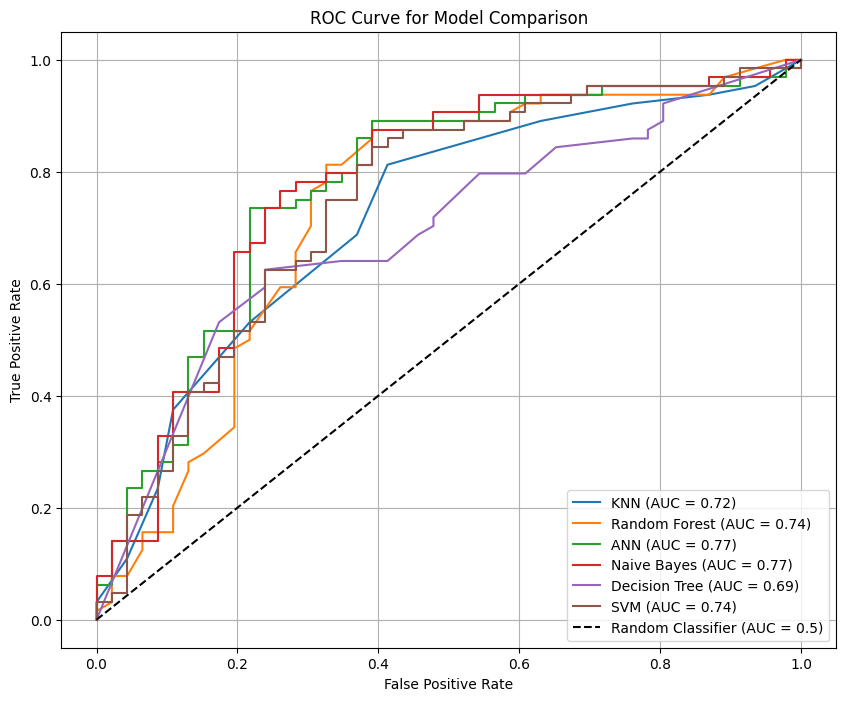

In [62]:
# TATIANA ENG

# ROC CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# Step 1: Create and fit all models using shared X_train, y_train and X_test, y_test

# Scale features for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN
best_knn = KNeighborsClassifier(n_neighbors=best_n_knn)
best_knn.fit(X_train_scaled, y_train)

# Random Forest
best_rf = RandomForestClassifier(n_estimators=best_n_rf, max_depth=best_depth_rf, random_state=42)
best_rf.fit(X_train, y_train)

# ANN (already trained earlier as ann_best)

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Decision Tree (already trained earlier as best_dt)

# SVM
best_svc = SVC(C=grid_svc.best_params_['C'], kernel=grid_svc.best_params_['kernel'], probability=True, random_state=42)
best_svc.fit(X_train_scaled, y_train)

# Step 2: Define X_test inputs for each model (scaled or unscaled depending on model type)
X_test_dict = {
    'KNN': X_test_scaled,
    'Random Forest': X_test,
    'ANN': X_test_scaled,
    'Naive Bayes': X_test,
    'Decision Tree': X_test,
    'SVM': X_test_scaled
}

# Step 3: Define model dictionary (assumes models have been trained)
models = {
    'KNN': best_knn,
    'Random Forest': best_rf,
    'ANN': ann_best,
    'Naive Bayes': nb,
    'Decision Tree': best_dt,
    'SVM': best_svc
}

# Step 4: Use shared test labels for all
y_test_dict = {model_name: y_test for model_name in models.keys()}

# Step 5: Define the ROC plotting function
def plot_roc_curve(models, X_test_dict, y_test_dict):
    plt.figure(figsize=(10, 8))
    for model_name, model in models.items():
        X_test = X_test_dict[model_name]
        y_true = y_test_dict[model_name]

        # Get predicted probabilities for class 1
        y_prob = model.predict_proba(X_test)[:, 1]

        # Compute ROC
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc_score = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
    plt.title('ROC Curve for Model Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Step 6: Plot ROC curves
plot_roc_curve(models, X_test_dict, y_test_dict)

In [63]:
# TATIANA ENG

# AUC VALUES

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Re-scale features for models that require it (KNN, ANN, SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the best KNN model
best_knn = KNeighborsClassifier(n_neighbors=best_n_knn)
best_knn.fit(X_train_scaled, y_train)

# Train the best Random Forest model
best_rf = RandomForestClassifier(n_estimators=best_n_rf, max_depth=best_depth_rf, random_state=42)
best_rf.fit(X_train, y_train)

# Reuse ann_best (already trained)

# Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Reuse best_dt (Decision Tree already trained)

# Retrain best SVM with probability=True
best_svc = SVC(C=grid_svc.best_params_['C'], kernel=grid_svc.best_params_['kernel'], probability=True, random_state=42)
best_svc.fit(X_train_scaled, y_train)

# Define models dictionary
models = {
    'KNN': best_knn,
    'Random Forest': best_rf,
    'ANN': ann_best,
    'Naive Bayes': nb,
    'Decision Tree': best_dt,
    'SVM': best_svc
}

# Define corresponding test features (scaled if needed)
X_test_dict = {
    'KNN': X_test_scaled,
    'Random Forest': X_test,
    'ANN': X_test_scaled,
    'Naive Bayes': X_test,
    'Decision Tree': X_test,
    'SVM': X_test_scaled
}

# Define y_test (same for all models)
y_test_dict = {model_name: y_test for model_name in models.keys()}

# Function to calculate and print AUC values
def calculate_auc(models, X_test_dict, y_test_dict):
    """
    Calculates and prints the AUC values for multiple models.
    """
    print("AUC Scores by Model:")
    print("---------------------")
    for model_name, model in models.items():
        X_test = X_test_dict[model_name]
        y_true = y_test_dict[model_name]

        # Get predicted probabilities for positive class (1 = male)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate AUC
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc_score = auc(fpr, tpr)

        print(f"{model_name}: AUC = {auc_score:.4f}")

# Run the AUC calculation
calculate_auc(models, X_test_dict, y_test_dict)


AUC Scores by Model:
---------------------
KNN: AUC = 0.7215
Random Forest: AUC = 0.7362
ANN: AUC = 0.7741
Naive Bayes: AUC = 0.7738
Decision Tree: AUC = 0.6929
SVM: AUC = 0.7446


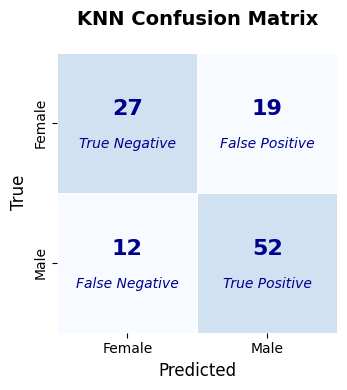

In [66]:
# TATIANA ENG

# CONFUSION MATRICES

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# STEP 1: Scale X_test where needed
X_test_scaled = StandardScaler().fit(X_train).transform(X_test)

# STEP 2: Define a reusable plotting function
def plot_confusion_matrix(model_name, cm):
    """
    Plots a single labeled confusion matrix.
    """
    plt.figure(figsize=(4, 4))

    # Base color layer (for consistent grid size)
    base_matrix = [[0.2, 0.0],
                   [0.0, 0.2]]
    ax = sns.heatmap(base_matrix, annot=False, fmt='d', cmap='Blues', cbar=False,
                     xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'],
                     square=True, linewidths=0.5, vmin=0, vmax=1)

    # Overlay true values and labels
    for i in range(2):
        for j in range(2):
            label = [["True Negative", "False Positive"],
                     ["False Negative", "True Positive"]][i][j]
            value = cm[i][j]
            plt.text(j + 0.5, i + 0.4, str(value), ha="center", va="center",
                     color="darkblue", fontsize=16, fontweight='bold')
            plt.text(j + 0.5, i + 0.65, label, ha="center", va="center",
                     color="darkblue", fontsize=10, style='italic')

    plt.title(f'{model_name} Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.tight_layout()
    plt.show()

# STEP 3: Create functions for each model
def plot_knn_confusion_matrix():
    cm = confusion_matrix(y_test, best_knn.predict(X_test_scaled))
    plot_confusion_matrix("KNN", cm)

def plot_rf_confusion_matrix():
    cm = confusion_matrix(y_test, best_rf.predict(X_test))
    plot_confusion_matrix("Random Forest", cm)

def plot_ann_confusion_matrix():
    cm = confusion_matrix(y_test, ann_best.predict(X_test_scaled))
    plot_confusion_matrix("ANN", cm)

def plot_nb_confusion_matrix():
    cm = confusion_matrix(y_test, nb.predict(X_test))
    plot_confusion_matrix("Naive Bayes", cm)

def plot_dt_confusion_matrix():
    cm = confusion_matrix(y_test, best_dt.predict(X_test))
    plot_confusion_matrix("Decision Tree", cm)

def plot_svc_confusion_matrix():
    cm = confusion_matrix(y_test, best_svc.predict(X_test_scaled))
    plot_confusion_matrix("Support Vector Machine", cm)

# STEP 4: Uncomment the function you want to visualize
plot_knn_confusion_matrix()
# plot_rf_confusion_matrix()
# plot_ann_confusion_matrix()
# plot_nb_confusion_matrix()
# plot_dt_confusion_matrix()
# plot_svc_confusion_matrix()